# Import Required Libraries 

In [1]:
import os
import numpy as np
import pandas as pd
# Pandas Options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize

import json
import requests
import re
from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns; sns.set_theme()

%matplotlib inline 

import folium
from folium import plugins
from folium.plugins import HeatMap

from sklearn.cluster import KMeans

print('Libraries Imported.')

Libraries Imported.


# Tables of Contents ....

# 1. Introduction / Business Case 

# 2. Data

## 2.1 Demographic Data 

In [2]:
# Define Function to load and process demographic csv

def process_demographic_csv(file_path):
    # 1. Read csv to pandas df, skip 2 rows, set column 0 as index
    df = pd.read_csv(file_path, skiprows=2, index_col=0)
    
    # 2. Drop last two columns (Arlington totals)
    df.drop(df.columns[-2:], axis=1, inplace=True)
    
    # 3. Convert percent column to floats
    df['Percent'] = df['Percent'].str.rstrip('%').astype('float') / 100.0
    
    # 4. Replace Total rows Percent with Number 
    df['Percent'].mask(df.index.str.contains('TOTAL'), df['Number'], inplace=True)
    
    # 5. Drop Number column 
    df.drop(columns=['Number'], inplace=True)
    
    # 6. Rename percent to neighborhood name
    df.columns = [df.index.name]
    df.index.name = None
    
    # 7. drop na 
    df.dropna(inplace=True)
    
    # 8. Transpose df
    df = df.T
    
    return df

Load the Census Data 

In [3]:
# Load Example of Demographic CSV

DEMOGRAPHIC_PATH = r'data/demographics/csv/'

# For all demographic csv in directory load & process
demographic_dfs = [process_demographic_csv(DEMOGRAPHIC_PATH+file) for file in os.listdir(DEMOGRAPHIC_PATH)]

# Concat into a single data frame 
arlington_demographics = pd.concat(demographic_dfs)
arlington_demographics

,TOTAL POPULATION,Total Non-Hispanic or Latino,White alone,Black or African-American alone,American Indian or Alaska Native alone,Asian alone,Native Hawaiian or Pacific Islander Alone,Some other Race alone,Two or more Races,Total Hispanic or Latino,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,Male,Female,TOTAL HOUSEHOLDS,Family households:,Husband-wife family,Other family:,"Male householder, no wife present","Female householder, no husband present",Nonfamily households:,Householder living alone,Householder not living alone,1-person household,2-person household,3-person household,4-person household,5-person household,6-person household,7-or-more-person household,TOTAL HOUSING UNITS,Occupied Housing Units,Owner-Occupied,Renter-Occupied,Vacant Housing Units
Lyon Park,"4,862",0.904,0.747,0.044,0.001,0.088,0.000,0.001,0.023,0.096,0.051,0.089,0.115,0.345,0.154,0.111,0.078,0.037,0.013,0.007,0.506,0.494,"2,370",0.368,0.306,0.062,0.020,0.042,0.632,0.435,0.198,0.435,0.312,0.114,0.099,0.028,0.005,0.007,2526,0.938,0.359,0.579,0.062
Madison Manor,"1,370",0.953,0.848,0.009,0.002,0.061,0.000,0.001,0.031,0.047,0.073,0.186,0.052,0.120,0.172,0.150,0.134,0.053,0.042,0.019,0.515,0.485,495,0.749,0.655,0.095,0.026,0.069,0.251,0.154,0.097,0.154,0.329,0.196,0.253,0.059,0.006,0.004,505,0.980,0.826,0.154,0.020
Yorktown,"3,616",0.939,0.845,0.021,0.001,0.044,0.000,0.002,0.025,0.061,0.076,0.194,0.056,0.097,0.156,0.158,0.147,0.057,0.042,0.017,0.489,0.511,"1,279",0.758,0.668,0.091,0.027,0.063,0.242,0.168,0.073,0.168,0.321,0.200,0.194,0.087,0.013,0.018,1319,0.970,0.850,0.120,0.030
Arlington View,979,0.896,0.190,0.619,0.012,0.057,0.001,0.001,0.015,0.104,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,0.487,0.513,376,0.598,0.298,0.301,0.077,0.223,0.402,0.287,0.114,0.287,0.309,0.165,0.122,0.056,0.029,0.032,391,0.962,0.517,0.445,0.038
Boulevard Manor,"1,828",0.777,0.580,0.057,0.002,0.106,0.000,0.001,0.031,0.223,0.068,0.159,0.068,0.109,0.142,0.135,0.112,0.063,0.058,0.085,0.474,0.526,678,0.640,0.493,0.147,0.035,0.112,0.360,0.301,0.059,0.301,0.280,0.142,0.162,0.058,0.034,0.024,713,0.951,0.544,0.407,0.049
Bellevue Forest,"1,043",0.961,0.910,0.012,0.001,0.027,0.000,0.001,0.011,0.039,0.051,0.206,0.039,0.035,0.134,0.199,0.189,0.072,0.053,0.021,0.493,0.507,392,0.796,0.742,0.054,0.020,0.033,0.204,0.166,0.038,0.166,0.367,0.217,0.166,0.064,0.015,0.005,402,0.975,0.935,0.040,0.025
Arlington Forest,"2,223",0.927,0.823,0.017,0.001,0.047,0.004,0.001,0.034,0.073,0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,0.506,0.494,834,0.685,0.613,0.072,0.018,0.054,0.315,0.207,0.108,0.207,0.317,0.194,0.211,0.049,0.013,0.008,852,0.979,0.823,0.156,0.021
Westover Village,"2,209",0.827,0.639,0.068,0.003,0.082,0.000,0.002,0.033,0.173,0.070,0.133,0.074,0.232,0.177,0.139,0.105,0.047,0.014,0.010,0.495,0.505,"1,097",0.433,0.307,0.126,0.036,0.089,0.567,0.478,0.089,0.478,0.243,0.119,0.120,0.031,0.007,0.002,1150,0.954,0.288,0.666,0.046
Columbia Heights,"4,985",0.854,0.496,0.159,0.004,0.162,0.000,0.003,0.028,0.146,0.058,0.063,0.098,0.340,0.175,0.120,0.088,0.035,0.018,0.006,0.482,0.518,"2,842",0.309,0.225,0.084,0.025,0.058,0.691,0.543,0.148,0.543,0.284,0.093,0.054,0.018,0.004,0.005,2994,0.949,0.225,0.724,0.051
Ballston - Virginia Square,"13,753",0.948,0.773,0.029,0.001,0.118,0.000,0.002,0.025,0.052,0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,0.502,0.498,"8,218",0.240,0.203,0.038,0.014,0.023,0.760,0.514,0.245,0.514,0.363,0.083,0.031,0.007,0.001,0.001,8861,0.927,0.329,0.598,0.073


In [4]:
# Sort Data Frame Alphabetically 

arlington_demographics.sort_index(inplace=True)
arlington_demographics

,TOTAL POPULATION,Total Non-Hispanic or Latino,White alone,Black or African-American alone,American Indian or Alaska Native alone,Asian alone,Native Hawaiian or Pacific Islander Alone,Some other Race alone,Two or more Races,Total Hispanic or Latino,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,Male,Female,TOTAL HOUSEHOLDS,Family households:,Husband-wife family,Other family:,"Male householder, no wife present","Female householder, no husband present",Nonfamily households:,Householder living alone,Householder not living alone,1-person household,2-person household,3-person household,4-person household,5-person household,6-person household,7-or-more-person household,TOTAL HOUSING UNITS,Occupied Housing Units,Owner-Occupied,Renter-Occupied,Vacant Housing Units
Alcova Heights,"1,900",0.761,0.582,0.047,0.003,0.097,0.000,0.003,0.029,0.239,0.075,0.116,0.078,0.205,0.169,0.163,0.121,0.047,0.019,0.006,0.490,0.510,745,0.580,0.474,0.106,0.030,0.077,0.420,0.278,0.142,0.278,0.340,0.168,0.106,0.064,0.019,0.026,784,0.950,0.696,0.254,0.050
Arlington Forest,"2,223",0.927,0.823,0.017,0.001,0.047,0.004,0.001,0.034,0.073,0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,0.506,0.494,834,0.685,0.613,0.072,0.018,0.054,0.315,0.207,0.108,0.207,0.317,0.194,0.211,0.049,0.013,0.008,852,0.979,0.823,0.156,0.021
Arlington Heights,"2,555",0.770,0.576,0.060,0.002,0.101,0.003,0.004,0.025,0.230,0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,0.499,0.501,"1,032",0.529,0.414,0.115,0.029,0.086,0.471,0.326,0.145,0.326,0.309,0.167,0.102,0.044,0.020,0.033,1070,0.964,0.595,0.369,0.036
Arlington Ridge,"6,324",0.937,0.733,0.040,0.003,0.132,0.001,0.002,0.027,0.063,0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,0.479,0.521,"3,549",0.352,0.313,0.039,0.012,0.026,0.648,0.492,0.156,0.492,0.343,0.090,0.051,0.016,0.006,0.002,3755,0.945,0.416,0.529,0.055
Arlington View,979,0.896,0.190,0.619,0.012,0.057,0.001,0.001,0.015,0.104,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,0.487,0.513,376,0.598,0.298,0.301,0.077,0.223,0.402,0.287,0.114,0.287,0.309,0.165,0.122,0.056,0.029,0.032,391,0.962,0.517,0.445,0.038
Arlingwood,366,0.959,0.888,0.019,0.005,0.025,0.000,0.008,0.014,0.041,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,0.478,0.522,136,0.809,0.750,0.059,0.029,0.029,0.191,0.162,0.029,0.162,0.382,0.140,0.243,0.066,0.007,0.000,148,0.919,0.851,0.068,0.081
Ashton Heights,"3,962",0.856,0.685,0.063,0.001,0.082,0.000,0.003,0.022,0.144,0.049,0.108,0.111,0.281,0.142,0.126,0.112,0.048,0.017,0.007,0.521,0.479,"1,715",0.451,0.363,0.087,0.027,0.060,0.549,0.362,0.188,0.362,0.304,0.152,0.122,0.036,0.017,0.007,1777,0.965,0.385,0.580,0.035
Aurora Highlands,"8,725",0.907,0.680,0.082,0.003,0.113,0.000,0.001,0.028,0.093,0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,0.491,0.509,"4,804",0.297,0.255,0.042,0.012,0.030,0.703,0.507,0.196,0.507,0.326,0.095,0.050,0.014,0.006,0.003,5514,0.871,0.124,0.747,0.129
Ballston - Virginia Square,"13,753",0.948,0.773,0.029,0.001,0.118,0.000,0.002,0.025,0.052,0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,0.502,0.498,"8,218",0.240,0.203,0.038,0.014,0.023,0.760,0.514,0.245,0.514,0.363,0.083,0.031,0.007,0.001,0.001,8861,0.927,0.329,0.598,0.073
Barcroft,"3,477",0.632,0.497,0.050,0.002,0.057,0.001,0.003,0.022,0.368,0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,0.529,0.471,"1,285",0.602,0.461,0.141,0.068,0.073,0.398,0.267,0.131,0.267,0.282,0.163,0.168,0.065,0.031,0.024,1327,0.968,0.518,0.451,0.032


In [5]:
# Drop all unwanted columns

columns = [
    'TOTAL POPULATION',
    'Under 5 years',
    '5 to 17 years',
    '18 to 24 years',
    '25 to 34 years',
    '35 to 44 years',
    '45 to 54 years',
    '55 to 64 years',
    '65 to 74 years',
    '75 to 84 years',
    '85 years and over',
    'TOTAL HOUSEHOLDS',
    'Family households:',
    'Nonfamily households:',
    'TOTAL HOUSING UNITS',
    'Occupied Housing Units',
    'Vacant Housing Units',
]
arlington_demographics = arlington_demographics[columns]
arlington_demographics

,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,Family households:,Nonfamily households:,TOTAL HOUSING UNITS,Occupied Housing Units,Vacant Housing Units
Alcova Heights,"1,900",0.075,0.116,0.078,0.205,0.169,0.163,0.121,0.047,0.019,0.006,745,0.580,0.420,784,0.950,0.050
Arlington Forest,"2,223",0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,834,0.685,0.315,852,0.979,0.021
Arlington Heights,"2,555",0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,"1,032",0.529,0.471,1070,0.964,0.036
Arlington Ridge,"6,324",0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,"3,549",0.352,0.648,3755,0.945,0.055
Arlington View,979,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,376,0.598,0.402,391,0.962,0.038
Arlingwood,366,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,136,0.809,0.191,148,0.919,0.081
Ashton Heights,"3,962",0.049,0.108,0.111,0.281,0.142,0.126,0.112,0.048,0.017,0.007,"1,715",0.451,0.549,1777,0.965,0.035
Aurora Highlands,"8,725",0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,"4,804",0.297,0.703,5514,0.871,0.129
Ballston - Virginia Square,"13,753",0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,"8,218",0.240,0.760,8861,0.927,0.073
Barcroft,"3,477",0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,"1,285",0.602,0.398,1327,0.968,0.032


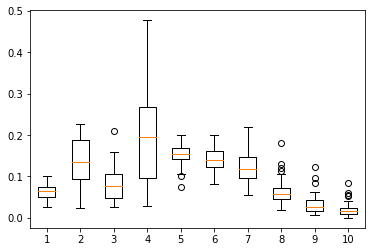

In [6]:
arlington_age_demographics = arlington_demographics.iloc[:, 1:11] # .multiply(arlington_demographics['TOTAL POPULATION'], axis="index")
fig, ax = plt.subplots()
ax.boxplot(arlington_age_demographics)
plt.show()

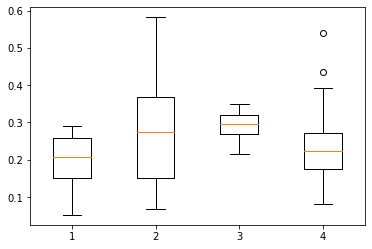

In [7]:
b1 = arlington_demographics['Under 5 years'] + arlington_demographics['5 to 17 years']
b2 = arlington_demographics['18 to 24 years'] + arlington_demographics['25 to 34 years']
b3 = arlington_demographics['35 to 44 years'] + arlington_demographics['45 to 54 years'] #+ arlington_demographics['55 to 64 years']
b4 = arlington_demographics['65 to 74 years'] + arlington_demographics['75 to 84 years'] + arlington_demographics['85 years and over'] + arlington_demographics['55 to 64 years']

data = [b1, b2, b3, b4]
fig, ax = plt.subplots()
ax.boxplot(data)
plt.show()

In [8]:
arlington_demographics.insert(1, 'under 18 years old', b1)
arlington_demographics.insert(2, '18 to 34 years old', b2)
arlington_demographics.insert(3, '35 to 54 years old', b3)
arlington_demographics.insert(4, 'over 54 years old', b4)
arlington_demographics = arlington_demographics.drop(columns=[
    'Under 5 years',
    '5 to 17 years',
    '18 to 24 years',
    '25 to 34 years',
    '35 to 44 years',
    '45 to 54 years',
    '55 to 64 years',
    '65 to 74 years',
    '75 to 84 years',
    '85 years and over'])
arlington_demographics

,TOTAL POPULATION,under 18 years old,18 to 34 years old,35 to 54 years old,over 54 years old,TOTAL HOUSEHOLDS,Family households:,Nonfamily households:,TOTAL HOUSING UNITS,Occupied Housing Units,Vacant Housing Units
Alcova Heights,"1,900",0.191,0.283,0.332,0.193,745,0.580,0.420,784,0.950,0.050
Arlington Forest,"2,223",0.256,0.179,0.341,0.224,834,0.685,0.315,852,0.979,0.021
Arlington Heights,"2,555",0.187,0.276,0.341,0.195,"1,032",0.529,0.471,1070,0.964,0.036
Arlington Ridge,"6,324",0.097,0.371,0.263,0.269,"3,549",0.352,0.648,3755,0.945,0.055
Arlington View,979,0.210,0.259,0.298,0.232,376,0.598,0.402,391,0.962,0.038
Arlingwood,366,0.274,0.069,0.270,0.388,136,0.809,0.191,148,0.919,0.081
Ashton Heights,"3,962",0.157,0.392,0.268,0.184,"1,715",0.451,0.549,1777,0.965,0.035
Aurora Highlands,"8,725",0.087,0.466,0.257,0.189,"4,804",0.297,0.703,5514,0.871,0.129
Ballston - Virginia Square,"13,753",0.052,0.571,0.216,0.160,"8,218",0.240,0.760,8861,0.927,0.073
Barcroft,"3,477",0.207,0.325,0.296,0.171,"1,285",0.602,0.398,1327,0.968,0.032


In [9]:
arlington_demographics.rename(columns={"Family households:": "family households", 
                                       "Nonfamily households:": "nonfamily households",
                                       "Nonfamily households:": "nonfamily households",
                                       "Occupied Housing Units": "occupied housing units",
                                       "Vacant Housing Units": "vacant housing units"
                                      }, inplace=True)
arlington_demographics

,TOTAL POPULATION,under 18 years old,18 to 34 years old,35 to 54 years old,over 54 years old,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units
Alcova Heights,"1,900",0.191,0.283,0.332,0.193,745,0.580,0.420,784,0.950,0.050
Arlington Forest,"2,223",0.256,0.179,0.341,0.224,834,0.685,0.315,852,0.979,0.021
Arlington Heights,"2,555",0.187,0.276,0.341,0.195,"1,032",0.529,0.471,1070,0.964,0.036
Arlington Ridge,"6,324",0.097,0.371,0.263,0.269,"3,549",0.352,0.648,3755,0.945,0.055
Arlington View,979,0.210,0.259,0.298,0.232,376,0.598,0.402,391,0.962,0.038
Arlingwood,366,0.274,0.069,0.270,0.388,136,0.809,0.191,148,0.919,0.081
Ashton Heights,"3,962",0.157,0.392,0.268,0.184,"1,715",0.451,0.549,1777,0.965,0.035
Aurora Highlands,"8,725",0.087,0.466,0.257,0.189,"4,804",0.297,0.703,5514,0.871,0.129
Ballston - Virginia Square,"13,753",0.052,0.571,0.216,0.160,"8,218",0.240,0.760,8861,0.927,0.073
Barcroft,"3,477",0.207,0.325,0.296,0.171,"1,285",0.602,0.398,1327,0.968,0.032


In [10]:
arlington_demographics['TOTAL POPULATION'] = arlington_demographics['TOTAL POPULATION'].str.replace(',', '').astype('int')
arlington_demographics['TOTAL HOUSEHOLDS'] = arlington_demographics['TOTAL HOUSEHOLDS'].str.replace(',', '').astype('int')
arlington_demographics['TOTAL HOUSING UNITS'] = arlington_demographics['TOTAL HOUSING UNITS'].str.replace(',', '').astype('int')
arlington_demographics

,TOTAL POPULATION,under 18 years old,18 to 34 years old,35 to 54 years old,over 54 years old,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units
Alcova Heights,1900,0.191,0.283,0.332,0.193,745,0.580,0.420,784,0.950,0.050
Arlington Forest,2223,0.256,0.179,0.341,0.224,834,0.685,0.315,852,0.979,0.021
Arlington Heights,2555,0.187,0.276,0.341,0.195,1032,0.529,0.471,1070,0.964,0.036
Arlington Ridge,6324,0.097,0.371,0.263,0.269,3549,0.352,0.648,3755,0.945,0.055
Arlington View,979,0.210,0.259,0.298,0.232,376,0.598,0.402,391,0.962,0.038
Arlingwood,366,0.274,0.069,0.270,0.388,136,0.809,0.191,148,0.919,0.081
Ashton Heights,3962,0.157,0.392,0.268,0.184,1715,0.451,0.549,1777,0.965,0.035
Aurora Highlands,8725,0.087,0.466,0.257,0.189,4804,0.297,0.703,5514,0.871,0.129
Ballston - Virginia Square,13753,0.052,0.571,0.216,0.160,8218,0.240,0.760,8861,0.927,0.073
Barcroft,3477,0.207,0.325,0.296,0.171,1285,0.602,0.398,1327,0.968,0.032


### - Explore Demographic Data

##  2.2 Arlington Neighborhood Location Data 

In [11]:
def fetch_location(neigh):
    address = neigh + ', Arlington County, Virginia'
    geolocator = Nominatim(user_agent="my_explorer")
    location = geolocator.geocode(address)
    return location

# Define Columns 
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe 
arlington_neighborhoods_location = pd.DataFrame(columns=column_names)

for i, n in enumerate(arlington_demographics.index):
    if '/' in n or '-' in n:
        s = re.split('/|-', n)
        sum_lat, sum_long, cnt = 0, 0, 0
        for _n in s:
            location = fetch_location(_n)
            lat, long = (location.latitude, location.longitude) if location else (None, None)
            if(lat and long):
                cnt += 1
                sum_lat += lat
                sum_long += long
        lat, long = sum_lat/cnt if sum_lat != 0 else np.nan , sum_long/cnt if sum_long != 0 else np.nan 

    else:
        location = fetch_location(n)
        lat, long = (location.latitude, location.longitude) if location else (np.nan, np.nan)
        
    arlington_neighborhoods_location.loc[i] = [n, lat, long]
arlington_neighborhoods_location

,Neighborhood,Latitude,Longitude
0,Alcova Heights,38.864557,-77.097201
1,Arlington Forest,38.868856,-77.113084
2,Arlington Heights,38.869557,-77.092201
3,Arlington Ridge,38.890396,-77.084159
4,Arlington View,38.863079,-77.072591
5,Arlingwood,38.927611,-77.121923
6,Ashton Heights,NaN,NaN
7,Aurora Highlands,38.859493,-77.061664
8,Ballston - Virginia Square,38.882475,-77.107412
9,Barcroft,38.855946,-77.103868


In [12]:
arlington_neighborhoods_location[arlington_neighborhoods_location.isna().any(axis=1)]

,Neighborhood,Latitude,Longitude
6,Ashton Heights,NaN,NaN
12,Boulevard Manor,NaN,NaN
15,Cherry Valley Nature Area,NaN,NaN
29,Forest Glen,NaN,NaN
36,John M Langston,NaN,NaN
37,Leeway Overlee,NaN,NaN
52,Rock Spring,NaN,NaN
54,Tara Leeway Heights,NaN,NaN
55,Waverly Hills,NaN,NaN
58,Williamsburg,NaN,NaN


In [13]:
location_patches = [
['Arlington Ridge', 38.85357, -77.06798],
['Ashton Heights', 38.87615, -77.10072],
['Aurora Highlands', 38.85420, -77.06106],
['Barcroft', 38.86201, -77.11044],
['Bluemont', 38.87823, -77.12106],
['Boulevard Manor', 38.87007, -77.13587],
['Buckingham', 38.87216, -77.10995],
['Cherrydale', 38.87216, -77.10872],
['Donaldson Run', 38.90617, -77.11617],
['Forest Glen', 38.85914, -77.12141],
['Forest Hills', 38.86952, -77.11799],
['Old Glebe', 38.92017, -77.12938],
['Rock Spring', 38.91049, -77.14109],
['Waverly Hills', 38.89593, -77.11817],
['Williamsburg', 38.90016, -77.15657]]

for l in location_patches:
    arlington_neighborhoods_location.loc[(arlington_neighborhoods_location.Neighborhood == l[0]), ['Latitude', 'Longitude']] = l[1:]
arlington_neighborhoods_location.set_index('Neighborhood', inplace=True)
arlington_neighborhoods_location

,Latitude,Longitude
Neighborhood,,
Alcova Heights,38.864557,-77.097201
Arlington Forest,38.868856,-77.113084
Arlington Heights,38.869557,-77.092201
Arlington Ridge,38.853570,-77.067980
Arlington View,38.863079,-77.072591
Arlingwood,38.927611,-77.121923
Ashton Heights,38.876150,-77.100720
Aurora Highlands,38.854200,-77.061060
Ballston - Virginia Square,38.882475,-77.107412


In [14]:
arlington_neighborhoods_location.dropna(inplace=True)
arlington_neighborhoods_location

,Latitude,Longitude
Neighborhood,,
Alcova Heights,38.864557,-77.097201
Arlington Forest,38.868856,-77.113084
Arlington Heights,38.869557,-77.092201
Arlington Ridge,38.853570,-77.067980
Arlington View,38.863079,-77.072591
Arlingwood,38.927611,-77.121923
Ashton Heights,38.876150,-77.100720
Aurora Highlands,38.854200,-77.061060
Ballston - Virginia Square,38.882475,-77.107412


In [15]:
# get arlington county lat & long

address = 'Arlington County, Virginia'

geolocator = Nominatim(user_agent="my_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [16]:
map_arlington = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, neighborhood in zip(arlington_neighborhoods_location['Latitude'], arlington_neighborhoods_location['Longitude'], arlington_neighborhoods_location.index):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_arlington)
    

map_arlington

## 2.3 Alrington Neighborhood Venue Data 

In [17]:
# Four Square Credentials & Env 

CLIENT_ID = os.environ.get("FS_CLIENT_ID")
CLIENT_SECRET = os.environ.get("FS_CLIENT_SECRET")
ACCESS_TOKEN = os.environ.get("FS_ACCESS_TOKEN")

VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value 

In [18]:
# Function to get Near By Venues 
def getNearbyVenues(names, latitudes, longitudes, radius=600):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        
        # API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # GET
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        print(name, "- Venues Found: ", len(results))
        
        # return list of relevant info for each venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
    return venues_list

In [19]:
# Get Venues with radius=500 of Neighborhoods
arlington_venues_list = getNearbyVenues(names=arlington_neighborhoods_location.index, 
                                   latitudes=arlington_neighborhoods_location['Latitude'], 
                                   longitudes=arlington_neighborhoods_location['Longitude'])

arlington_neighborhood_venues = pd.DataFrame([item for venue_list in arlington_venues_list for item in venue_list])
arlington_neighborhood_venues.columns = ['Neighborhood', 
                            'Neighborhood_Latitude', 
                            'Neighborhood_Longitude',
                            'Venue', 
                            'Venue_Latitude', 
                            'Venue_Longitude', 
                            'Venue_Category']

Alcova Heights - Venues Found:  20
Arlington Forest - Venues Found:  10
Arlington Heights - Venues Found:  5
Arlington Ridge - Venues Found:  5
Arlington View - Venues Found:  9
Arlingwood - Venues Found:  3
Ashton Heights - Venues Found:  17
Aurora Highlands - Venues Found:  12
Ballston - Virginia Square - Venues Found:  66
Barcroft - Venues Found:  7
Bellevue Forest - Venues Found:  4
Bluemont - Venues Found:  21
Boulevard Manor - Venues Found:  21
Buckingham - Venues Found:  15
Chain Bridge Forest - Venues Found:  4
Cherrydale - Venues Found:  21
Claremont - Venues Found:  22
Clarendon-Courthouse - Venues Found:  100
Colonial Village - Venues Found:  77
Columbia Forest - Venues Found:  12
Columbia Heights - Venues Found:  8
Columbia Heights West - Venues Found:  8
Dominion Hills - Venues Found:  7
Donaldson Run - Venues Found:  1
Douglas Park - Venues Found:  19
Dover Crystal - Venues Found:  5
East Falls Church - Venues Found:  18
Fairlington - Venues Found:  40
Forest Glen - Venue

In [20]:
arlington_neighborhood_venues

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Alcova Heights,38.864557,-77.097201,CycleBar,38.860825,-77.093112,Cycle Studio
1,Alcova Heights,38.864557,-77.097201,The Broiler,38.860738,-77.094114,American Restaurant
2,Alcova Heights,38.864557,-77.097201,Takohachi,38.861905,-77.091607,Japanese Restaurant
3,Alcova Heights,38.864557,-77.097201,Mom's Pizza,38.861997,-77.091642,Greek Restaurant
4,Alcova Heights,38.864557,-77.097201,Thomas Jefferson Community Center & Theatre,38.869751,-77.095811,School
5,Alcova Heights,38.864557,-77.097201,Redbox,38.868374,-77.097198,Video Store
6,Alcova Heights,38.864557,-77.097201,Burger King,38.860737,-77.094868,Fast Food Restaurant
7,Alcova Heights,38.864557,-77.097201,7-Eleven,38.860358,-77.094095,Convenience Store
8,Alcova Heights,38.864557,-77.097201,Chipotle Mexican Grill,38.860952,-77.092255,Mexican Restaurant
9,Alcova Heights,38.864557,-77.097201,Mattress Firm,38.862086,-77.091354,Mattress Store


In [21]:
arlington_neighborhood_venues.shape

(1087, 7)

In [22]:
print('There are {} uniques categories and {} unique Venues.'.format(len(arlington_neighborhood_venues['Venue_Category'].unique()), len(arlington_neighborhood_venues['Venue'].unique())))

There are 204 uniques categories and 714 unique Venues.


In [23]:
arlington_neighborhood_venues['Venue_Category'].value_counts()

Park                                        65
Coffee Shop                                 33
Trail                                       31
Sandwich Place                              28
Pizza Place                                 27
Convenience Store                           25
Gym / Fitness Center                        24
Food Truck                                  23
Grocery Store                               22
Mexican Restaurant                          21
Gym                                         19
Hotel                                       19
Pharmacy                                    18
Café                                        17
American Restaurant                         17
Middle Eastern Restaurant                   16
Mediterranean Restaurant                    16
Thai Restaurant                             15
Chinese Restaurant                          15
Bar                                         14
Dog Run                                     13
Bank         

In [24]:
# Get Date Frame Of Food Trucks From Venues

arlington_neighborhood_food_trucks = arlington_neighborhood_venues[arlington_neighborhood_venues['Venue_Category'] == 'Food Truck']

arlington_neighborhood_food_trucks

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
324,Clarendon-Courthouse,38.888484,-77.089243,La Tingeria,38.891447,-77.084740,Food Truck
369,Colonial Village,38.892392,-77.080983,"Tacos ""El Chilango""",38.890531,-77.077326,Food Truck
382,Colonial Village,38.892392,-77.080983,La Tingeria,38.891447,-77.084740,Food Truck
405,Colonial Village,38.892392,-77.080983,Chef On Wheels,38.891131,-77.083711,Food Truck
420,Colonial Village,38.892392,-77.080983,Tacos Matadores,38.891355,-77.084813,Food Truck
424,Colonial Village,38.892392,-77.080983,Choupi Crepes,38.896699,-77.077433,Food Truck
475,Douglas Park,38.853087,-77.097329,DC Slices,38.848970,-77.097093,Food Truck
480,Douglas Park,38.853087,-77.097329,Dirty South Deli,38.848908,-77.096851,Food Truck
482,Douglas Park,38.853087,-77.097329,Peruvian Brothers,38.848330,-77.097019,Food Truck
497,Dover Crystal,38.906778,-77.105812,Muncheez Lebanese Food,38.910186,-77.100908,Food Truck


In [25]:
arlington_neighborhood_food_trucks.shape

(23, 7)

In [26]:
# Drop Food Trucks from Neighborhood Venues 
arlington_neighborhood_venues.drop(arlington_neighborhood_venues[arlington_neighborhood_venues['Venue_Category'] == 'Food Truck'].index, inplace=True)
arlington_neighborhood_venues['Venue_Category'].value_counts()

Park                                        65
Coffee Shop                                 33
Trail                                       31
Sandwich Place                              28
Pizza Place                                 27
Convenience Store                           25
Gym / Fitness Center                        24
Grocery Store                               22
Mexican Restaurant                          21
Gym                                         19
Hotel                                       19
Pharmacy                                    18
Café                                        17
American Restaurant                         17
Middle Eastern Restaurant                   16
Mediterranean Restaurant                    16
Chinese Restaurant                          15
Thai Restaurant                             15
Bar                                         14
Yoga Studio                                 13
Bank                                        13
Dog Run      

### - get generalized venue categories 

In [27]:
URL = r'https://developer.foursquare.com/docs/build-with-foursquare/categories/'


page = requests.get(URL)
soup = BeautifulSoup(page.text, 'html.parser')

def get_sub_categories(foobar):
    sub_list = foobar.find('ul',  {'class': 'VenueCategories__Wrapper-sc-1ysxg0y-0 dikXMT'})
    sub_categories = [sub.find('h3').text for sub in sub_list.findAll('li', recursive=True)]
    return sub_categories

ul = soup.find('ul',  {'class': 'VenueCategories__Wrapper-sc-1ysxg0y-0 dikXMT'})
general_categories = ul.findAll('li', recursive=False)
general_venue_categories = {gen.find('h3').text: get_sub_categories(gen) for gen in general_categories}

general_venue_categories

{'Arts & Entertainment': ['Amphitheater',
  'Aquarium',
  'Arcade',
  'Art Gallery',
  'Bowling Alley',
  'Casino',
  'Circus',
  'Comedy Club',
  'Concert Hall',
  'Country Dance Club',
  'Disc Golf',
  'Exhibit',
  'General Entertainment',
  'Go Kart Track',
  'Historic Site',
  'Karaoke Box',
  'Laser Tag',
  'Memorial Site',
  'Mini Golf',
  'Movie Theater',
  'Drive-in Theater',
  'Indie Movie Theater',
  'Multiplex',
  'Museum',
  'Art Museum',
  'Erotic Museum',
  'History Museum',
  'Planetarium',
  'Science Museum',
  'Music Venue',
  'Jazz Club',
  'Piano Bar',
  'Rock Club',
  'Pachinko Parlor',
  'Performing Arts Venue',
  'Dance Studio',
  'Indie Theater',
  'Opera House',
  'Theater',
  'Pool Hall',
  'Public Art',
  'Outdoor Sculpture',
  'Street Art',
  'Racecourse',
  'Racetrack',
  'Roller Rink',
  'Salsa Club',
  'Samba School',
  'Stadium',
  'Baseball Stadium',
  'Basketball Stadium',
  'Cricket Ground',
  'Football Stadium',
  'Hockey Arena',
  'Rugby Stadium',
  

In [28]:
# Get Generalized Venue Categories 

def get_general_venue_category(category):
    for k, i in general_venue_categories.items():
        if category in i: return k
    return "Misc"

for i, row in arlington_neighborhood_venues.iterrows():
    new_category = get_general_venue_category(row['Venue_Category'])
#     print(row['Venue_Category'], '-->', new_category)
    arlington_neighborhood_venues.loc[i, 'Venue_Category'] = get_general_venue_category(row['Venue_Category'])

arlington_neighborhood_venues['Venue_Category'].value_counts()

Food                           428
Shop & Service                 299
Outdoors & Recreation          223
Nightlife Spot                  42
Travel & Transport              31
Arts & Entertainment            22
Professional & Other Places     12
Residence                        4
Misc                             3
Name: Venue_Category, dtype: int64

In [29]:
# Drop All Misc
arlington_neighborhood_venues.drop(arlington_neighborhood_venues[arlington_neighborhood_venues['Venue_Category'] == 'Misc'].index, inplace=True)
arlington_neighborhood_venues['Venue_Category'].value_counts()

Food                           428
Shop & Service                 299
Outdoors & Recreation          223
Nightlife Spot                  42
Travel & Transport              31
Arts & Entertainment            22
Professional & Other Places     12
Residence                        4
Name: Venue_Category, dtype: int64

In [30]:
# add Food Trucks back
arlington_neighborhood_venues = pd.concat([arlington_neighborhood_venues, arlington_neighborhood_food_trucks])
arlington_neighborhood_venues['Venue_Category'].value_counts()

Food                           428
Shop & Service                 299
Outdoors & Recreation          223
Nightlife Spot                  42
Travel & Transport              31
Food Truck                      23
Arts & Entertainment            22
Professional & Other Places     12
Residence                        4
Name: Venue_Category, dtype: int64

In [31]:
arlington_neighborhood_venues

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Alcova Heights,38.864557,-77.097201,CycleBar,38.860825,-77.093112,Outdoors & Recreation
1,Alcova Heights,38.864557,-77.097201,The Broiler,38.860738,-77.094114,Food
2,Alcova Heights,38.864557,-77.097201,Takohachi,38.861905,-77.091607,Food
3,Alcova Heights,38.864557,-77.097201,Mom's Pizza,38.861997,-77.091642,Food
4,Alcova Heights,38.864557,-77.097201,Thomas Jefferson Community Center & Theatre,38.869751,-77.095811,Professional & Other Places
5,Alcova Heights,38.864557,-77.097201,Redbox,38.868374,-77.097198,Shop & Service
6,Alcova Heights,38.864557,-77.097201,Burger King,38.860737,-77.094868,Food
7,Alcova Heights,38.864557,-77.097201,7-Eleven,38.860358,-77.094095,Shop & Service
8,Alcova Heights,38.864557,-77.097201,Chipotle Mexican Grill,38.860952,-77.092255,Food
9,Alcova Heights,38.864557,-77.097201,Mattress Firm,38.862086,-77.091354,Shop & Service


In [32]:
# one hot encoding 
arlington_neighborhood_venues_onehot = pd.get_dummies(arlington_neighborhood_venues[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
arlington_neighborhood_venues_onehot['Neighborhood'] = arlington_neighborhood_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [arlington_neighborhood_venues_onehot.columns[-1]] + list(arlington_neighborhood_venues_onehot.columns[:-1])
arlington_neighborhood_venues_onehot = arlington_neighborhood_venues_onehot[fixed_columns]

arlington_neighborhood_venues_onehot

,Neighborhood,Arts & Entertainment,Food,Food Truck,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Alcova Heights,0,0,0,0,1,0,0,0,0
1,Alcova Heights,0,1,0,0,0,0,0,0,0
2,Alcova Heights,0,1,0,0,0,0,0,0,0
3,Alcova Heights,0,1,0,0,0,0,0,0,0
4,Alcova Heights,0,0,0,0,0,1,0,0,0
5,Alcova Heights,0,0,0,0,0,0,0,1,0
6,Alcova Heights,0,1,0,0,0,0,0,0,0
7,Alcova Heights,0,0,0,0,0,0,0,1,0
8,Alcova Heights,0,1,0,0,0,0,0,0,0
9,Alcova Heights,0,0,0,0,0,0,0,1,0


In [33]:
arlington_neighborhood_venues_freq = arlington_neighborhood_venues_onehot.groupby('Neighborhood').mean().reset_index()
arlington_neighborhood_venues_freq

,Neighborhood,Arts & Entertainment,Food,Food Truck,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Alcova Heights,0.000000,0.526316,0.000000,0.000000,0.210526,0.052632,0.000000,0.210526,0.000000
1,Arlington Forest,0.000000,0.600000,0.000000,0.000000,0.200000,0.000000,0.000000,0.200000,0.000000
2,Arlington Heights,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.400000,0.200000
3,Arlington Ridge,0.600000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000
4,Arlington View,0.000000,0.222222,0.000000,0.222222,0.222222,0.000000,0.000000,0.222222,0.111111
5,Arlingwood,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000
6,Ashton Heights,0.000000,0.882353,0.000000,0.000000,0.000000,0.000000,0.000000,0.117647,0.000000
7,Aurora Highlands,0.000000,0.500000,0.000000,0.166667,0.250000,0.000000,0.000000,0.083333,0.000000
8,Ballston - Virginia Square,0.015152,0.545455,0.000000,0.030303,0.196970,0.015152,0.000000,0.181818,0.015152
9,Barcroft,0.000000,0.142857,0.000000,0.000000,0.571429,0.000000,0.000000,0.285714,0.000000


In [34]:

for hood in arlington_neighborhood_venues_freq['Neighborhood']:
    print("-----"+hood+"-----")
    temp = arlington_neighborhood_venues_freq[arlington_neighborhood_venues_freq['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True))
    print('\n') 

-----Alcova Heights-----
                         venue  freq
0                         Food  0.53
1        Outdoors & Recreation  0.21
2               Shop & Service  0.21
3  Professional & Other Places  0.05
4         Arts & Entertainment  0.00
5                   Food Truck  0.00
6               Nightlife Spot  0.00
7                    Residence  0.00
8           Travel & Transport  0.00


-----Arlington Forest-----
                         venue  freq
0                         Food   0.6
1        Outdoors & Recreation   0.2
2               Shop & Service   0.2
3         Arts & Entertainment   0.0
4                   Food Truck   0.0
5               Nightlife Spot   0.0
6  Professional & Other Places   0.0
7                    Residence   0.0
8           Travel & Transport   0.0


-----Arlington Heights-----
                         venue  freq
0               Shop & Service   0.4
1        Outdoors & Recreation   0.2
2  Professional & Other Places   0.2
3           Travel & Transpo

In [35]:
arlington_neighborhood_venues_freq.set_index('Neighborhood', inplace=True)
arlington_neighborhood_venues_freq

,Arts & Entertainment,Food,Food Truck,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
Neighborhood,,,,,,,,,
Alcova Heights,0.000000,0.526316,0.000000,0.000000,0.210526,0.052632,0.000000,0.210526,0.000000
Arlington Forest,0.000000,0.600000,0.000000,0.000000,0.200000,0.000000,0.000000,0.200000,0.000000
Arlington Heights,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.400000,0.200000
Arlington Ridge,0.600000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000
Arlington View,0.000000,0.222222,0.000000,0.222222,0.222222,0.000000,0.000000,0.222222,0.111111
Arlingwood,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000
Ashton Heights,0.000000,0.882353,0.000000,0.000000,0.000000,0.000000,0.000000,0.117647,0.000000
Aurora Highlands,0.000000,0.500000,0.000000,0.166667,0.250000,0.000000,0.000000,0.083333,0.000000
Ballston - Virginia Square,0.015152,0.545455,0.000000,0.030303,0.196970,0.015152,0.000000,0.181818,0.015152


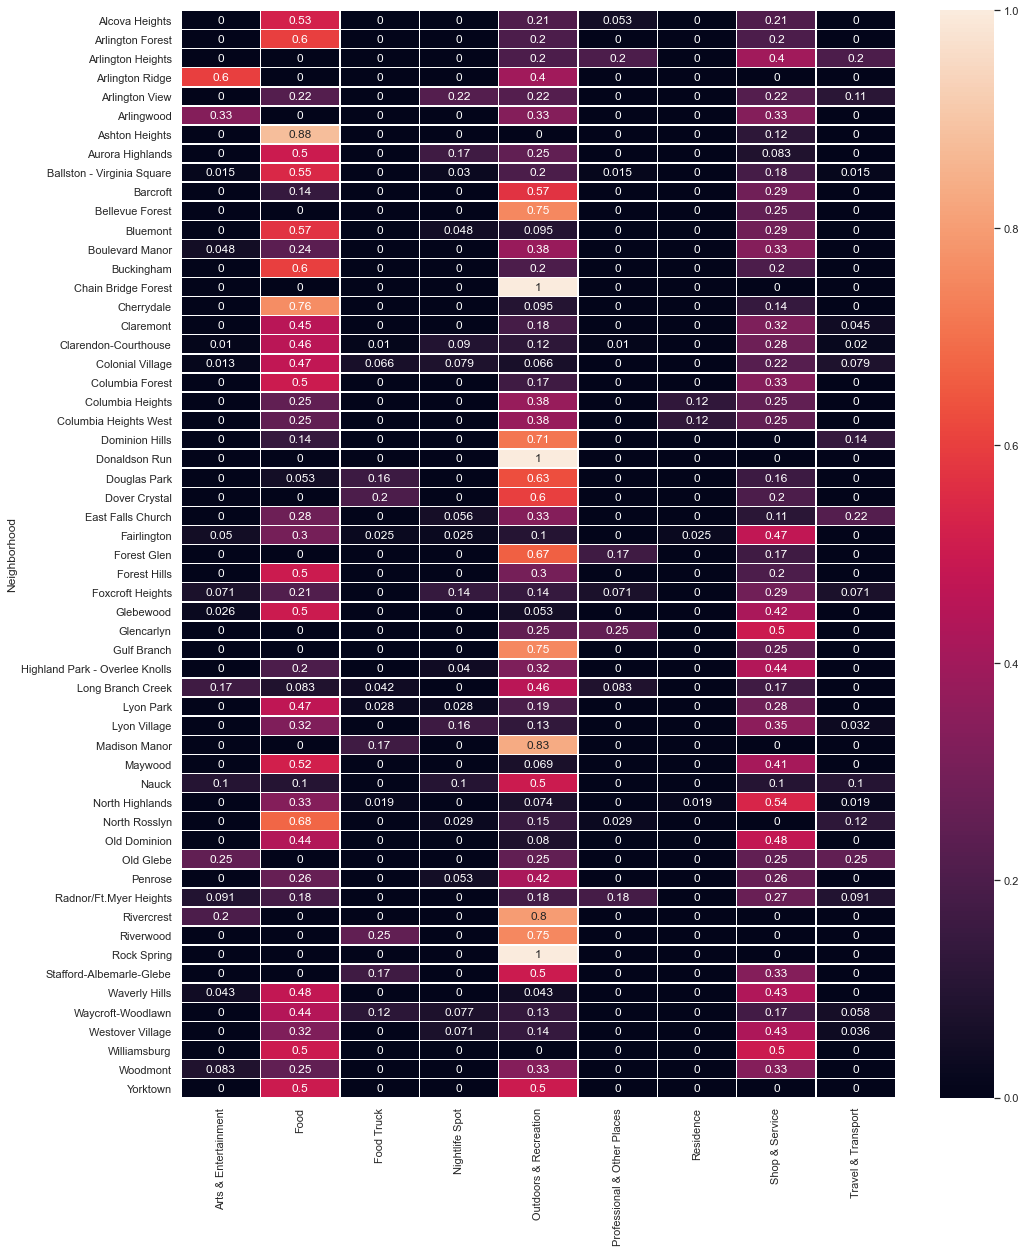

In [50]:
fig, ax = plt.subplots(figsize=(16, 20))
sns.heatmap(ax=ax, data=arlington_neighborhood_venues_freq, annot=True, linewidths=.5, square=False)
plt.show()

### Explore Venue Data Frame 

## 2.4 Combine all the data 

In [37]:
# arlington_neighborhoods = arlington_neighborhoods.join(arlington_neighborhood_venues_freq, on="Neighborhood")
# arlington_neighborhoods

arlington_neighborhoods = pd.concat([arlington_neighborhoods_location, arlington_demographics, arlington_neighborhood_venues_freq], axis=1, join="inner")
arlington_neighborhoods

,Latitude,Longitude,TOTAL POPULATION,under 18 years old,18 to 34 years old,35 to 54 years old,over 54 years old,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Food Truck,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
Alcova Heights,38.864557,-77.097201,1900,0.191,0.283,0.332,0.193,745,0.580,0.420,784,0.950,0.050,0.000000,0.526316,0.000000,0.000000,0.210526,0.052632,0.000000,0.210526,0.000000
Arlington Forest,38.868856,-77.113084,2223,0.256,0.179,0.341,0.224,834,0.685,0.315,852,0.979,0.021,0.000000,0.600000,0.000000,0.000000,0.200000,0.000000,0.000000,0.200000,0.000000
Arlington Heights,38.869557,-77.092201,2555,0.187,0.276,0.341,0.195,1032,0.529,0.471,1070,0.964,0.036,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.400000,0.200000
Arlington Ridge,38.853570,-77.067980,6324,0.097,0.371,0.263,0.269,3549,0.352,0.648,3755,0.945,0.055,0.600000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000
Arlington View,38.863079,-77.072591,979,0.210,0.259,0.298,0.232,376,0.598,0.402,391,0.962,0.038,0.000000,0.222222,0.000000,0.222222,0.222222,0.000000,0.000000,0.222222,0.111111
Arlingwood,38.927611,-77.121923,366,0.274,0.069,0.270,0.388,136,0.809,0.191,148,0.919,0.081,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000
Ashton Heights,38.876150,-77.100720,3962,0.157,0.392,0.268,0.184,1715,0.451,0.549,1777,0.965,0.035,0.000000,0.882353,0.000000,0.000000,0.000000,0.000000,0.000000,0.117647,0.000000
Aurora Highlands,38.854200,-77.061060,8725,0.087,0.466,0.257,0.189,4804,0.297,0.703,5514,0.871,0.129,0.000000,0.500000,0.000000,0.166667,0.250000,0.000000,0.000000,0.083333,0.000000
Ballston - Virginia Square,38.882475,-77.107412,13753,0.052,0.571,0.216,0.160,8218,0.240,0.760,8861,0.927,0.073,0.015152,0.545455,0.000000,0.030303,0.196970,0.015152,0.000000,0.181818,0.015152
Barcroft,38.862010,-77.110440,3477,0.207,0.325,0.296,0.171,1285,0.602,0.398,1327,0.968,0.032,0.000000,0.142857,0.000000,0.000000,0.571429,0.000000,0.000000,0.285714,0.000000
